In [44]:
from pathlib import Path
from typing import Tuple
from collections import defaultdict

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from matplotlib import pyplot as plt
import numpy as np

import seaborn as sns

# TODO

- [ ] Appliquer le reduction sur les 3 
- [ ] essayer de faire la diff de chrom entre les 3 
- [ ] essayer d'overfitter pour voir si le modèle peut apprendre
- [ ] Attention au temps de suivi: si qqn a pas d'événement, c'est pê que le temps de suivi est pas assez long. Il vaudrait mieux les supprimer
- [ ] nouvelle variable histologique : bon ou mauvais répondeur
- [ ] eux font le NMF. Ici les données sont + sparse car dans le sang, et pas sur la tumeur.
- [ ] censurer les patiens qui viennent d'arriver

# Descrition des données

## metadata
1 ligne par fichier, des fois 2 ; dans le cas où il y a 2 lignes prendre la ligne où le CPA est le plus élevé (correspond à une seconde analyse  où plus de séquence d'ADN ont été analysée)

* CPA = % d'altération. Nb d'altération détectée par rapport à une baseline. Estimation de la quantité d'adn de la tumer qui se trouve dans le sang, c'est une valeur pas un pourcentage
* nb.reads = dans un premier temsp on s'enffiche (valeur qui permet de normaliser) Nombre de séquences scanées. Si très bas on fait moins confiance. 
* sexe
* age
* htum = grosseur de la tumeur au diagnostisque (ie le jour ou on fait la radio)
* relapse = 1 rechute, 0 pas rechute
* etat 2 = statut du patient (mot ou vivant, 0 vivant, 1 décédé)
* id.x = id patient
* time_point = 3 valeurs possibles (DIAG, AVANT_CHIR, FIN_TTT)
* time_OS = durée de suivi total
* time_PFS = nombre de jour entre la rechute et le diagnostique
* rep_histo: reponse histologique : bon ou mauvais répondeur. On l'a après le 1er traitement
* puberte + parlant que l'âge
* meta_bis : présence de métastase au diagnostique


## data
En fonction des patients on n'a pas tous les times point
* Diagnotisque
* Avt chirurgie (déjà un traitement)
* Fin T : fin traitnement

Chaque chromosome est découpé en fenetre => mêmes fenetres pour tous les patients

Indicateur de présence d'adn tumoral (0 : 2 copies, > 0 copie en trop, < 0 perte)

# Preprocess data

## Load files

In [160]:
metadata_path = Path('..') / 'data' / 'raw' / 'metadata_DMLHT_ctDNA.csv'

In [163]:
metadata = pd.read_csv(metadata_path, sep='\t', skiprows=1)

In [178]:
metadata_path_old = Path('..') / 'data' / 'raw' / 'metadata_OS2006_ctdna.csv'
data_dir = Path('..') / 'data' / 'raw' / 'results'

In [179]:
metadata_old = pd.read_csv(metadata_path2)

In [174]:
col_desc = !head -n 1 ../data/raw/metadata_DMLHT_ctDNA.csv
col_desc = pd.concat([pd.Series(metadata.columns), pd.Series(col_desc[0].split('\t'))], axis=1)
col_desc.columns = ['col_name', 'desc']
col_desc

,col_name,desc
0,sex,Genre du patient
1,age,Age du patient (années)
2,pub,Stade pubertaire
3,htum,hauteur de la tumeur (mm)
4,meta_bis,Présence (ou non) de metastase au diagnostic
5,chimgr,Type de chimio
6,rep_histo,réponse histologique : bonne (GR) ou mauvaise ...
7,relapse,"Rechute (1=oui, 0= non)"
8,etat2,Statut vital (1 =décédé)
9,time_OS,Survie globale jusqu’à la dernière date de sui...


In [184]:
def get_infos_from_filename(filename: str) -> Tuple[str, str]:
    filename = filename.split('.')[0]
    splitted_filename = filename.split('_')
    id_patient = f'{splitted_filename[0]}_{splitted_filename[1]}'
    time_point = f'{splitted_filename[2]}_{splitted_filename[3]}' if len(splitted_filename) == 4 else splitted_filename[2]
    return id_patient, time_point

In [185]:
def load_all_data_patient(data_dir: Path) -> defaultdict:
    data_patient = defaultdict(dict)

    for p in data_dir.iterdir():
        if not p.is_file():
            continue
        filename = str(p).split('/')[-1]
        id_patient, time_point = get_infos_from_filename(filename)
        data_patient[id_patient][time_point] = pd.read_csv(p, sep='\t')
    
    return data_patient

In [186]:
data_patient = load_all_data_patient(data_dir)
print(f'There are {len(data_patient)} patient')

There are 182 patient


## Organize data

In [10]:
patient_all_time_points = {patient_id: data for patient_id, data in data_patient.items() if len(data) == 3}
print(f'There are {len(patient_all_time_points)} patient with data for the 3 time points')

There are 115 patient with data for the 3 time points


In [11]:
patient_diag_time_point = {patient_id: {'DIAG': data['DIAG']} for patient_id, data in data_patient.items() if data.get('DIAG') is not None}
print(f'There are {len(patient_diag_time_point)} patient with data for DIAG time point')

There are 177 patient with data for DIAG time point


In [12]:
patient_chir_time_point = {patient_id: {'AVANT_CHIR': data['AVANT_CHIR']} for patient_id, data in data_patient.items() if data.get('AVANT_CHIR') is not None}
print(f'There are {len(patient_chir_time_point)} patient with data for AVANT_CHIR time point')

There are 143 patient with data for AVANT_CHIR time point


In [13]:
patient_end_time_point = {patient_id: {'FIN_TT': data['FIN_TT']} for patient_id, data in data_patient.items() if data.get('FIN_TT') is not None}
print(f'There are {len(patient_end_time_point)} patient with data for FIN_TT time point')

There are 143 patient with data for FIN_TT time point


## Check no error

In [14]:
nb_files = 0
for data in data_patient.values():
    nb_files += len(data.values())
nb_files

463

In [15]:
177 + 143 * 2

463

## Transform data
### Transpose data

In [24]:
def transpose_data_one_patient(data: pd.DataFrame) -> pd.DataFrame:
    one_data = data.copy()
    one_data = one_data[['id', 'ratio', 'zscore']].set_index('id').stack().reset_index()
    one_data.columns = ['id', 'score_label', 'value']
    one_data['col_name'] = one_data['id'] + '_' + one_data['score_label']
    return one_data.set_index('col_name')['value'].to_frame().T

In [17]:
def format_all_data_as_df(patient_data: defaultdict) -> pd.DataFrame:
    transpose_data = []
    ids_patient = []
    
    for patient_id, data in patient_data.items():
        for time_point, data in data.items():
            transpose_data.append(transpose_data_one_patient(data))
            ids_patient.append((patient_id, time_point))
        
    transpose_data_df = pd.concat(transpose_data, axis=0).reset_index(drop=True)
    ids_patient_df = pd.DataFrame(ids_patient, columns=['patient_id', 'time_point'])
    
    return pd.concat([ids_patient_df, transpose_data_df], axis=1)

In [18]:
patient_all_time_points_df = format_all_data_as_df(patient_all_time_points)

In [19]:
patient_diag_time_point_df = format_all_data_as_df(patient_diag_time_point)

In [20]:
patient_chir_time_point_df = format_all_data_as_df(patient_chir_time_point)

In [21]:
patient_end_time_point_df = format_all_data_as_df(patient_end_time_point)

## Clean metadata

In [22]:
metadata_df = metadata.copy()
del metadata_df['Unnamed: 0']

In [27]:
metadata_df = metadata_df.sort_values('CPA', ascending=False).drop_duplicates(['id.x', 'time_point'], keep='first')

In [28]:
metadata_df.rename(columns={'id.x': 'patient_id'}, inplace=True)
metadata_df['time_point'] = metadata_df['time_point'].str.replace('FIN_TTT', 'FIN_TT')

## Merge metadata and data

In [30]:
data_all_time_points = pd.merge(metadata_df, patient_all_time_points_df, on=['patient_id', 'time_point'], how='right')
columns_to_keep = ['patient_id', 'time_point'] + [col for col in data_all_time_points.columns if col.endswith('_ratio') or col.endswith('_zscore') or col == 'CPA']
data_all_time_points = data_all_time_points[columns_to_keep].set_index(['time_point', 'patient_id']).unstack('time_point')
data_all_time_points.columns = ['_'.join(col).strip() for col in data_all_time_points.columns.values]
data_all_time_points.reset_index(inplace=True)
data_all_time_points = pd.merge(
    metadata_df[['patient_id', 'sex', 'age', 'htum', 'relapse', 'etat2', "time_OS", "time_PFS"]], data_all_time_points, on='patient_id', how='right').drop_duplicates('patient_id').reset_index(drop=True)

In [31]:
data_diag = pd.merge(metadata_df, patient_diag_time_point_df, on=['patient_id', 'time_point'], how='right')
data_chir = pd.merge(metadata_df, patient_chir_time_point_df, on=['patient_id', 'time_point'], how='right')
data_end = pd.merge(metadata_df, patient_end_time_point_df, on=['patient_id', 'time_point'], how='right')

In [32]:
join_columns = ['patient_id', 'sex', 'age', 'htum', 'relapse']
columns_to_keep = join_columns + ['CPA']

metadata_diag = metadata_df.loc[metadata_df['time_point'] == 'DIAG', columns_to_keep]
metadata_diag.rename(columns={'CPA': 'CPA_DIAG'}, inplace=True)

metadata_chir = metadata_df.loc[metadata_df['time_point'] == 'AVANT_CHIR', columns_to_keep]
metadata_chir.rename(columns={'CPA': 'CPA_AVANT_CHIR'}, inplace=True)

metadata_end = metadata_df.loc[metadata_df['time_point'] == 'FIN_TT', columns_to_keep]
metadata_end.rename(columns={'CPA': 'CPA_FIN_TT'}, inplace=True)

metadata_patients_all_time_points = pd.merge(metadata_diag, metadata_chir, how='inner', on=join_columns)
metadata_patients_all_time_points = pd.merge(metadata_patients_all_time_points, metadata_end, how='inner', on=join_columns)

In [33]:
OUTPUT_DIR = Path('..') / 'data' / 'intermediate'

# all
data_all_time_points.to_csv(OUTPUT_DIR / 'data_all_time_point.csv', index=False)
metadata_patients_all_time_points.to_csv(OUTPUT_DIR / 'metadata.csv', index=False)

# per time
data_diag.to_csv(OUTPUT_DIR / "data_diag.csv", index=False)
data_chir.to_csv(OUTPUT_DIR / "data_chir.csv", index=False)
data_end.to_csv(OUTPUT_DIR / "data_end.csv", index=False)

# Load processed data

In [34]:
OUTPUT_DIR = Path('..') / 'data' / 'intermediate'

metadata_patients_all_time_points = pd.read_csv(OUTPUT_DIR / 'metadata.csv')
data_diag = pd.read_csv(OUTPUT_DIR / 'diag.csv')
data_all = pd.read_csv(OUTPUT_DIR / 'data_all_time_point.csv')

In [36]:
data_all.head()

,patient_id,sex,age,htum,relapse,etat2,time_OS,time_PFS,CPA_AVANT_CHIR,CPA_DIAG,...,Y:21000001-22000000_ratio_FIN_TT,Y:21000001-22000000_zscore_AVANT_CHIR,Y:21000001-22000000_zscore_DIAG,Y:21000001-22000000_zscore_FIN_TT,Y:56000001-57000000_ratio_AVANT_CHIR,Y:56000001-57000000_ratio_DIAG,Y:56000001-57000000_ratio_FIN_TT,Y:56000001-57000000_zscore_AVANT_CHIR,Y:56000001-57000000_zscore_DIAG,Y:56000001-57000000_zscore_FIN_TT
0,OS2006_1,Feminin,17.58,10.6,0.0,0.0,2999.0,NaN,0.13178,0.15446,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OS2006_10,Masculin,14.51,11.1,0.0,1.0,607.0,NaN,0.12377,0.34361,...,-0.011403,-0.425711,1.538056,-0.209107,-0.006372,-0.084078,-0.067204,-0.229573,-1.442374,-1.568502
2,OS2006_11,Masculin,18.83,7.0,0.0,0.0,2581.0,NaN,0.11279,0.17640,...,-0.131256,-0.501901,-1.155128,-4.294767,0.135906,0.177465,0.205231,4.687495,4.854536,7.090777
3,OS2006_12,Feminin,11.69,12.4,0.0,0.0,445.0,122.0,0.27524,0.56731,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OS2006_149,Feminin,15.91,8.0,1.0,0.0,2440.0,550.0,0.14314,0.28877,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Analysis

In [37]:
metadata_patients_all_time_points.head()

,patient_id,sex,age,htum,relapse,CPA_DIAG,CPA_AVANT_CHIR,CPA_FIN_TT
0,OS2006_424,Feminin,12.91,9.3,1,1.73994,0.14075,0.16581
1,OS2006_489,Feminin,10.17,13.0,1,1.38208,0.22717,0.21355
2,OS2006_543,Feminin,15.62,15.0,1,1.37484,0.16444,0.17992
3,OS2006_252,Feminin,12.10,6.7,0,1.31617,0.25735,0.14705
4,OS2006_430,Feminin,8.25,7.0,0,1.25124,0.25564,0.16828


In [38]:
metadata_patients_all_time_points.relapse = metadata_patients_all_time_points.relapse.astype("category")

In [39]:
import plotly.express as px
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)

<AxesSubplot:ylabel='relapse'>

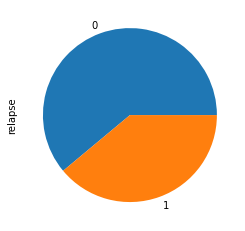

In [40]:
# dataset is balanced, we can use AUC as metric
metadata_patients_all_time_points.relapse.value_counts().plot(kind='pie')

/opt/homebrew/Caskroom/miniconda/base/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='time_OS', ylabel='Density'>

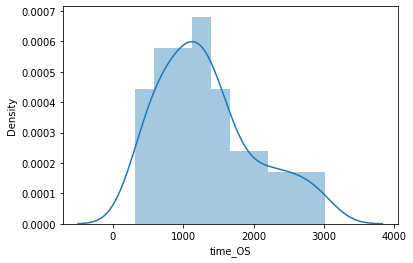

In [55]:
sns.distplot(data_all.time_OS, bins=10)

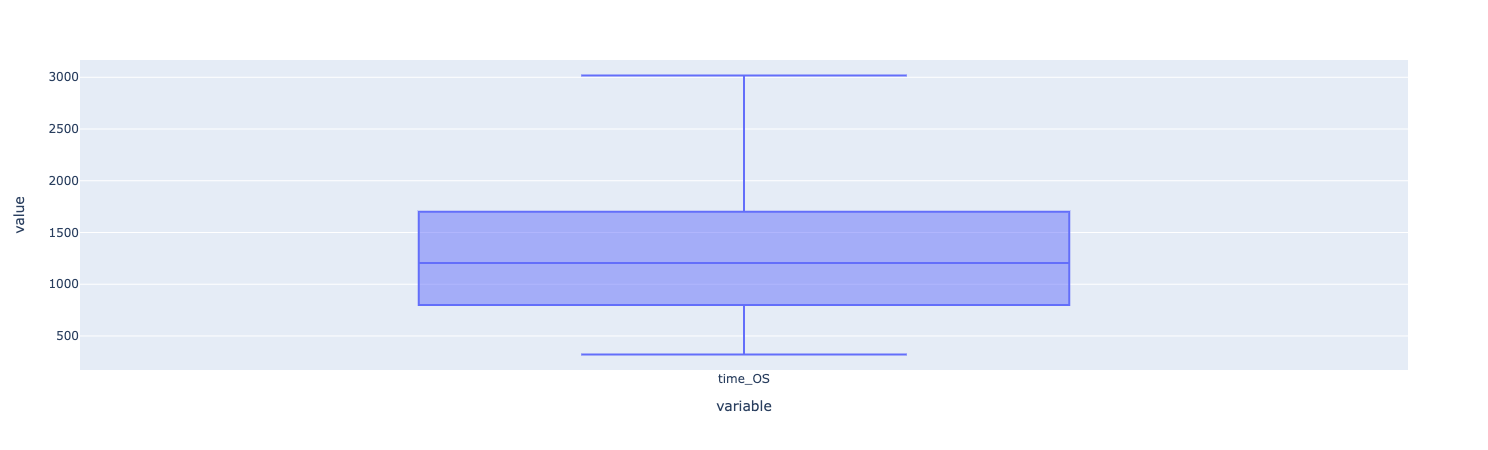

In [57]:
px.box(data_all.time_OS)

In [70]:
N_DAYS_MIN = 300

len(data_all[data_all.time_OS > N_DAYS_MIN])/len(data_all)

0.9478260869565217

## Outliers

In [63]:
outliers_ids = ['OS2006_34', 'OS2006_548', 'OS2006_20']

# ML models on metadata

## Compute features

In [71]:
data_all.head()

,patient_id,sex,age,htum,relapse,etat2,time_OS,time_PFS,CPA_AVANT_CHIR,CPA_DIAG,...,Y:21000001-22000000_ratio_FIN_TT,Y:21000001-22000000_zscore_AVANT_CHIR,Y:21000001-22000000_zscore_DIAG,Y:21000001-22000000_zscore_FIN_TT,Y:56000001-57000000_ratio_AVANT_CHIR,Y:56000001-57000000_ratio_DIAG,Y:56000001-57000000_ratio_FIN_TT,Y:56000001-57000000_zscore_AVANT_CHIR,Y:56000001-57000000_zscore_DIAG,Y:56000001-57000000_zscore_FIN_TT
0,OS2006_1,Feminin,17.58,10.6,0.0,0.0,2999.0,NaN,0.13178,0.15446,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OS2006_10,Masculin,14.51,11.1,0.0,1.0,607.0,NaN,0.12377,0.34361,...,-0.011403,-0.425711,1.538056,-0.209107,-0.006372,-0.084078,-0.067204,-0.229573,-1.442374,-1.568502
2,OS2006_11,Masculin,18.83,7.0,0.0,0.0,2581.0,NaN,0.11279,0.17640,...,-0.131256,-0.501901,-1.155128,-4.294767,0.135906,0.177465,0.205231,4.687495,4.854536,7.090777
3,OS2006_12,Feminin,11.69,12.4,0.0,0.0,445.0,122.0,0.27524,0.56731,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OS2006_149,Feminin,15.91,8.0,1.0,0.0,2440.0,550.0,0.14314,0.28877,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
features = data_all.copy()
print(f'Initial features shape : {features.shape}')

features['sex'] = features.apply(lambda x: 0 if x['sex'] == 'Feminin' else 1, axis=1)
features = features[~features['patient_id'].isin(outliers_ids)]
features.reset_index(drop=True, inplace=True)

print(f'Features shape after some cleaning: {features.shape}')

label = 'relapse'
labels = features[label]

data = features.copy()   # dataset with target for pycaret

Initial features shape : (115, 16025)
Features shape after some cleaning: (113, 16025)


In [81]:
CAT_FEATURES = ['sex']
NUM_FEATURES = ['age', 'htum', 'CPA_DIAG', 'CPA_AVANT_CHIR', 'CPA_FIN_TT']

data = data[CAT_FEATURES + NUM_FEATURES + [label]]

## First baseline with Pycaret

In [82]:
from pycaret.classification import *
from sklearn import __version__

print(__version__)

0.23.2


In [85]:
clf1 = setup(
    data,
    target=label,
    categorical_features=CAT_FEATURES,
    numeric_features=NUM_FEATURES,
    normalize=True,
    normalize_method='zscore',
    feature_selection=False,
)

,Description,Value
0,session_id,6485
1,Target,relapse
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(113, 7)"
5,Missing Values,True
6,Numeric Features,5
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [86]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.6786,0.0000,0.3667,0.5167,0.4138,0.2495,0.2627,0.0230
lda,Linear Discriminant Analysis,0.6786,0.6417,0.3667,0.5167,0.4138,0.2495,0.2627,0.0230
lr,Logistic Regression,0.6768,0.6350,0.4000,0.6000,0.4543,0.2623,0.2865,0.7600
nb,Naive Bayes,0.6482,0.6250,0.4333,0.5167,0.4638,0.2174,0.2129,0.0040
lightgbm,Light Gradient Boosting Machine,0.6286,0.5933,0.4000,0.5167,0.4438,0.1793,0.1831,0.1100
qda,Quadratic Discriminant Analysis,0.6125,0.5617,0.4000,0.4417,0.3995,0.1328,0.1330,0.1000
dummy,Dummy Classifier,0.6089,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0060
ada,Ada Boost Classifier,0.5893,0.6317,0.4667,0.4333,0.4326,0.1220,0.1295,0.0470
knn,K Neighbors Classifier,0.5857,0.5008,0.2667,0.3500,0.2871,0.0490,0.0538,0.0180
gbc,Gradient Boosting Classifier,0.5857,0.5700,0.4667,0.3650,0.4071,0.1105,0.0961,0.0270


In [87]:
# we create the model that maximize AUC
model = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5000,0.2667,0.0000,0.0000,0.0000,-0.2308,-0.2928
1,0.7500,0.4000,0.3333,1.0000,0.5000,0.3846,0.4880
2,0.6250,0.5333,0.3333,0.5000,0.4000,0.1429,0.1491
3,0.6250,0.8000,0.3333,0.5000,0.4000,0.1429,0.1491
4,0.6250,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.6250,0.8000,0.6667,0.5000,0.5714,0.2500,0.2582
6,0.8750,0.8000,0.6667,1.0000,0.8000,0.7143,0.7454
7,0.7143,1.0000,0.3333,1.0000,0.5000,0.3636,0.4714
8,0.5714,0.7500,0.6667,0.5000,0.5714,0.1600,0.1667
9,0.8571,1.0000,0.6667,1.0000,0.8000,0.6957,0.7303


In [88]:
tuned_model = tune_model(model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5000,0.2667,0.0000,0.0000,0.0000,-0.2308,-0.2928
1,0.7500,0.4000,0.3333,1.0000,0.5000,0.3846,0.4880
2,0.7500,0.5333,0.6667,0.6667,0.6667,0.4667,0.4667
3,0.6250,0.8000,0.3333,0.5000,0.4000,0.1429,0.1491
4,0.6250,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.6250,0.8000,0.6667,0.5000,0.5714,0.2500,0.2582
6,0.8750,0.8000,0.6667,1.0000,0.8000,0.7143,0.7454
7,0.7143,1.0000,0.3333,1.0000,0.5000,0.3636,0.4714
8,0.5714,0.7500,0.6667,0.5000,0.5714,0.1600,0.1667
9,0.8571,1.0000,0.6667,1.0000,0.8000,0.6957,0.7303


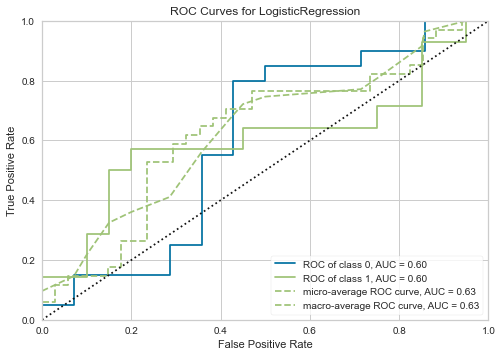

In [89]:
plot_model(tuned_model)

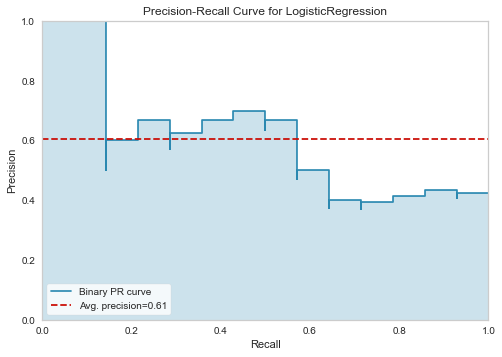

In [90]:
plot_model(tuned_model, plot = 'pr')

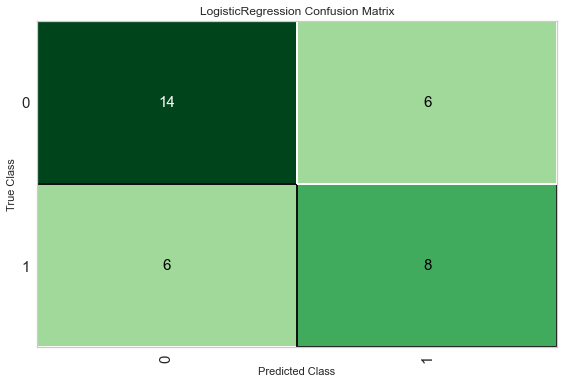

In [91]:
plot_model(tuned_model, plot = 'confusion_matrix')

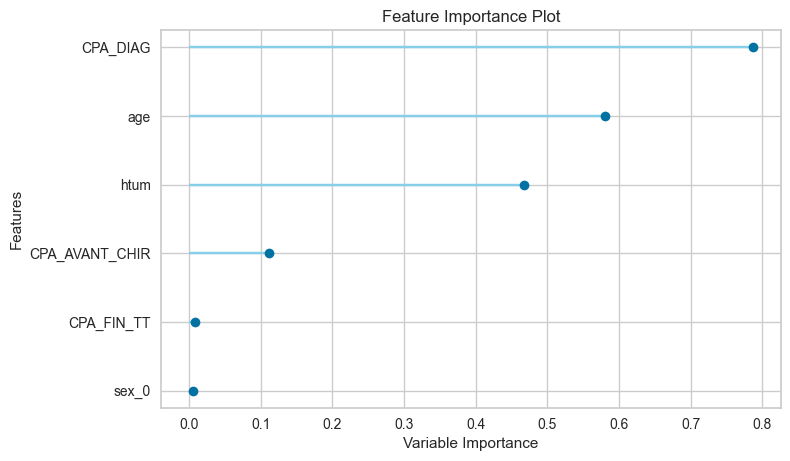

In [92]:
plot_model(tuned_model, plot = 'feature')

In [93]:
interpret_model(tuned_model)

TypeError: This function only supports tree based models for binary classification: rf, lightgbm, dt, et, xgboost.

# Processing gene data

## removing gene cols with missing values

In [94]:
ratio_cols = [col for col in data_diag.columns.tolist() if "ratio" in col]
zscore_cols = [col for col in data_diag.columns.tolist() if "zscore" in col]
gene_ratio = data_diag[ratio_cols]
gene_zscore = data_diag[zscore_cols]

<AxesSubplot:>

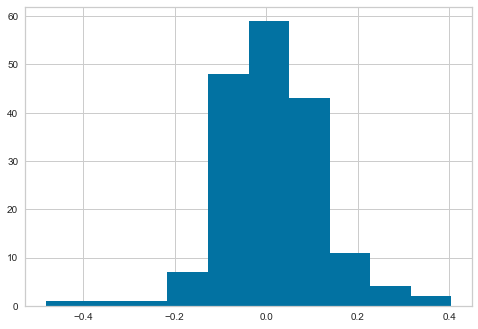

In [95]:
gene_ratio['1:1000001-2000000_ratio'].hist()

<AxesSubplot:>

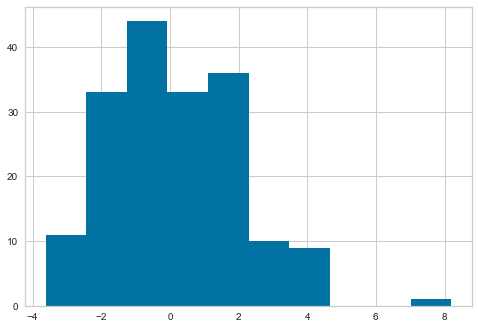

In [96]:
gene_zscore['1:1000001-2000000_zscore'].hist()

In [97]:
def compute_null_ratio(df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame(df.isna().sum()/len(df), columns=['null_ratio']).reset_index()

In [98]:
ratio_stats = compute_null_ratio(gene_ratio)
zscore_stats = compute_null_ratio(gene_zscore)

In [99]:
def plot_distribution(df: pd.DataFrame, threshold: float = 0.0) -> None:
    sub_df = df.query(f'null_ratio > {threshold}')
    sns.distplot(sub_df['null_ratio'])

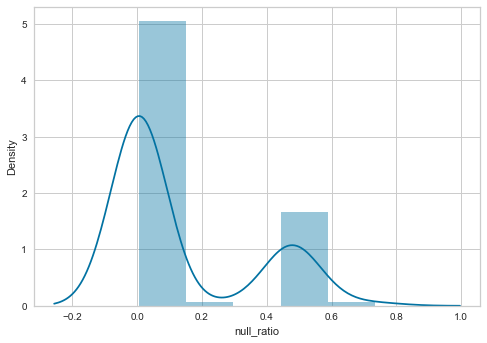

In [100]:
plot_distribution(ratio_stats)

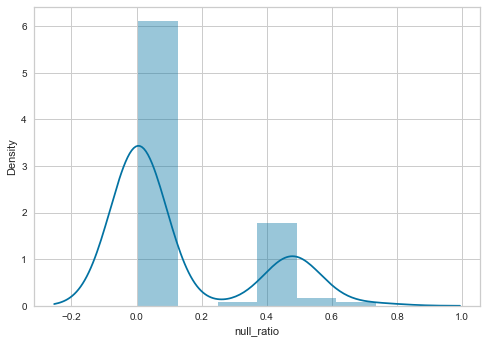

In [101]:
plot_distribution(zscore_stats)

In [102]:
both_stats = pd.concat(
    [
        ratio_stats,
        zscore_stats.rename(columns={'null_ratio': 'null_ratio_zscore', 'index': 'index_zscore'})
    ], axis=1)
both_stats.query("null_ratio != null_ratio_zscore")

,index,null_ratio,index_zscore,null_ratio_zscore
20,1:23000001-24000000_ratio,0.00565,1:23000001-24000000_zscore,0.00000
33,1:36000001-37000000_ratio,0.00000,1:36000001-37000000_zscore,0.00565
35,1:38000001-39000000_ratio,0.00000,1:38000001-39000000_zscore,0.00565
41,1:44000001-45000000_ratio,0.00565,1:44000001-45000000_zscore,0.00000
70,1:75000001-76000000_ratio,0.00000,1:75000001-76000000_zscore,0.00565
...,...,...,...,...
2416,20:56000001-57000000_ratio,0.00000,20:56000001-57000000_zscore,0.00565
2422,20:62000001-63000000_ratio,0.00565,20:62000001-63000000_zscore,0.00000
2448,21:35000001-36000000_ratio,0.00000,21:35000001-36000000_zscore,0.00565
2474,22:30000001-31000000_ratio,0.00565,22:30000001-31000000_zscore,0.00000


In [103]:
# we remove the columns with high null rates 
to_remove = both_stats.query('null_ratio > 0.2')
cols_to_remove = to_remove['index'].to_list() + to_remove['index_zscore'].to_list()
data_diag_clean = data_diag.drop(columns=cols_to_remove, errors='ignore')

ratio_cols = [col for col in data_diag_clean.columns.tolist() if "ratio" in col]
zscore_cols = [col for col in data_diag_clean.columns.tolist() if "zscore" in col]

In [104]:
for col in ratio_cols + zscore_cols:
    data_diag_clean[col] = data_diag_clean[col].fillna(0.0)

## Dimensionality reduction using UMAP

### First, visualization in 3D

In [105]:
def vector_numpy_to_pandas(umap_res: np.ndarray) -> pd.DataFrame:
    df = pd.DataFrame(umap_res)
    df = df.add_prefix('dim_')
    return df

In [106]:
import umap

N_DIMS = 3

fit = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=N_DIMS,
    metric='cosine',
    random_state=42
)

u = fit.fit_transform(data_diag_clean[zscore_cols].to_numpy())

features = data_diag_clean.iloc[:,:11]
vector = vector_numpy_to_pandas(u)
features = pd.concat([features, vector], axis=1)

features.head()

,CPA,Nb.Reads,sex,age,htum,relapse,etat2,patient_id,time_point,time_OS,time_PFS,dim_0,dim_1,dim_2
0,0.16176,17887776.0,Feminin,12.24,NaN,0.0,0.0,OS2006_581,DIAG,NaN,NaN,10.638923,5.541762,6.499124
1,1.20004,24753618.0,Masculin,8.47,9.1,1.0,1.0,OS2006_527,DIAG,400.0,313.0,12.984224,7.197556,4.815776
2,1.25124,3780606.0,Feminin,8.25,7.0,0.0,0.0,OS2006_430,DIAG,1676.0,NaN,13.514312,6.320854,5.400661
3,0.34353,7041729.0,Feminin,6.57,11.4,1.0,1.0,OS2006_279,DIAG,1555.0,1107.0,13.015133,5.619176,5.788889
4,0.39071,22523228.0,Masculin,13.30,7.0,0.0,0.0,OS2006_43,DIAG,2744.0,NaN,12.860094,8.018703,7.260830


In [107]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=True)
import plotly.graph_objs as go
import plotly.offline as py
import plotly.graph_objs as go
from IPython.display import Image,display

def plot_cluster(df, name=''):
    trace1 = go.Scatter3d(
        x=df['dim_0'],
        y=df['dim_1'],
        z=df['dim_2'],

        mode='markers',
        marker=dict(
            size=2,
            color=df["relapse"],
            colorscale='Viridis',   # choose a colorscale
            opacity=1
        ),
        text=df['relapse']
    )

    data = [trace1]
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
    fig = go.Figure(data=data, layout=layout)
    file='../reports/'+name+'.html'
    py.iplot(fig, filename=file)
    py.plot(fig, filename=file,auto_open=False)

In [109]:
# commented to save space when versionned 
#plot_cluster(features, 'umap')

### Compute vector of N dimensions

In [110]:
len(zscore_cols)

2645

In [121]:
import umap

N_DIMS = 10

fit = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=N_DIMS,
    metric='cosine',
    random_state=42
)

u = fit.fit_transform(data_diag_clean[zscore_cols].to_numpy())

features = data_all.iloc[:,:11]
vector = vector_numpy_to_pandas(u)
features = pd.concat([features, vector], axis=1)

# Train a ML model using all these features

In [123]:
features = features[~features['patient_id'].isin(outliers_ids)]

In [131]:
COLS_TO_DROP = ['patient_id', 'etat2', 'time_OS', 'time_PFS']
features = features.drop(columns=COLS_TO_DROP, errors='ignore')

In [132]:
features.head()

,sex,age,htum,relapse,CPA_AVANT_CHIR,CPA_DIAG,CPA_FIN_TT,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9
0,Feminin,17.58,10.6,0.0,0.13178,0.15446,0.12948,6.819944,6.741635,6.552502,3.163334,2.380113,4.450327,7.125168,9.759988,3.327932,5.137546
1,Masculin,14.51,11.1,0.0,0.12377,0.34361,0.14044,7.009439,7.755746,4.909565,1.374685,2.436057,5.700484,8.502618,10.000359,3.280427,5.533571
2,Masculin,18.83,7.0,0.0,0.11279,0.17640,0.14109,6.880323,7.230412,4.378039,1.720146,2.839537,5.274788,8.151042,10.238515,3.643500,5.489123
3,Feminin,11.69,12.4,0.0,0.27524,0.56731,0.17286,6.784331,7.194227,5.372379,2.115988,2.722812,5.398668,7.920492,10.083903,3.973462,5.517278
4,Feminin,15.91,8.0,1.0,0.14314,0.28877,0.15033,7.550785,7.845530,5.454696,1.102061,1.423698,4.822525,8.000863,11.224867,3.088291,4.955470


In [134]:
clf1 = setup(
    features,
    target=label,
    categorical_features=['sex'],
    numeric_features=['age', 'htum', 'CPA_DIAG', 'CPA_AVANT_CHIR', 'CPA_FIN_TT'] + [col for col in features.columns if col.startswith('dim_')],
    normalize=True,
    normalize_method='zscore',
    feature_selection=False,
)

,Description,Value
0,session_id,3771
1,Target,relapse
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(175, 17)"
5,Missing Values,True
6,Numeric Features,15
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [135]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.6196,0.0000,0.5083,0.6083,0.5194,0.2188,0.2402,0.0040
svm,SVM - Linear Kernel,0.6179,0.0000,0.6000,0.6133,0.5816,0.2318,0.2466,0.0090
lda,Linear Discriminant Analysis,0.6071,0.6542,0.4833,0.5917,0.4956,0.1938,0.2143,0.0050
lr,Logistic Regression,0.6054,0.6188,0.5167,0.5850,0.5276,0.2051,0.2169,0.6470
nb,Naive Bayes,0.5714,0.5562,0.4333,0.5500,0.4617,0.1300,0.1366,0.0040
dummy,Dummy Classifier,0.5357,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0100
gbc,Gradient Boosting Classifier,0.5071,0.4729,0.3333,0.4000,0.3538,-0.0076,-0.0282,0.0190
lightgbm,Light Gradient Boosting Machine,0.4911,0.4833,0.3583,0.4250,0.3629,-0.0355,-0.0349,0.1140
qda,Quadratic Discriminant Analysis,0.4857,0.4875,0.3500,0.3233,0.3233,-0.0344,-0.0434,0.0160
knn,K Neighbors Classifier,0.4804,0.4729,0.3333,0.4833,0.3714,-0.0369,-0.0370,0.0190


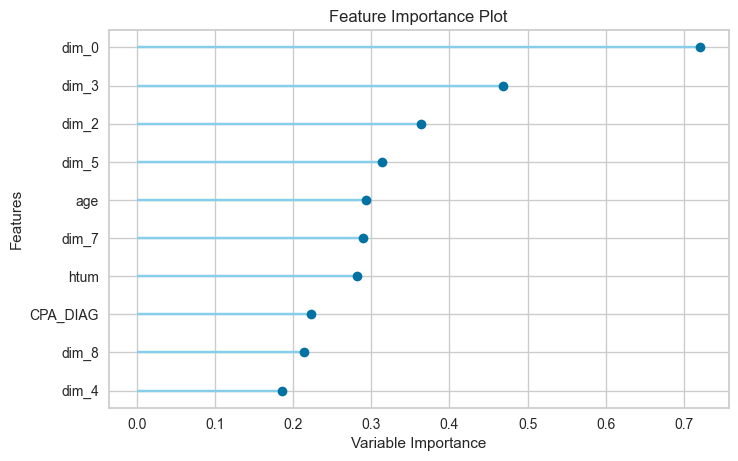

In [136]:
plot_model(best_model, plot = 'feature')

In [137]:
interpret_model(best_model)

TypeError: This function only supports tree based models for binary classification: rf, lightgbm, dt, et, xgboost.